In [1]:
import os
os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [2]:
import kagglehub
path = kagglehub.dataset_download("faresabbasai2022/skin-burns-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/skin-burns-dataset


In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jana7h","key":"951195c28b801fc0bd5df81c669d64fa"}'}

In [2]:
import os
import zipfile

# Set Kaggle config path
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d faresabbasai2022/skin-burns-dataset -p /content/data

# Unzip it
with zipfile.ZipFile("/content/data/skin-burns-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data")

print("✅ Dataset extracted to /content/data")


Dataset URL: https://www.kaggle.com/datasets/faresabbasai2022/skin-burns-dataset
License(s): apache-2.0
✅ Dataset extracted to /content/data


In [3]:
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

In [4]:
class SkinBurnsDataset(Dataset):
    def __init__(self, root_dir, transform=None, mode='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode

        self.image_files = []
        self.labels = []

        for subdir, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith(".jpg") or file.endswith(".png"):
                    file_path = os.path.join(subdir, file)
                    self.image_files.append(file_path)

                    if self.mode != 'test':
                        label = os.path.basename(os.path.dirname(file_path))
                        self.labels.append(label)

        if self.mode != 'test':
            self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set(self.labels)))}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.mode == 'test':
            return image
        else:
            label_name = self.labels[idx]
            label = self.label_to_idx[label_name]
            return image, label


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomVerticalFlip(),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])

])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])



# train_data_path = "data/datasets/faresabbasai2022/skin-burns-dataset/versions/1/skin burn dataset/train"
# train_dataset = SkinBurnsDataset(root_dir=train_data_path, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

# valid_data_path= "/content/data/datasets/faresabbasai2022/skin-burns-dataset/versions/1/skin burn dataset/valid"
# valid_dataset = SkinBurnsDataset(root_dir=valid_data_path, transform=val_transform)
# valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

# test_data_path = "/content/data/datasets/faresabbasai2022/skin-burns-dataset/versions/1/skin burn dataset/test"
# test_dataset = SkinBurnsDataset(root_dir=test_data_path, transform=transform, mode='test')
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)


train_data_path = "/content/data/skin burn dataset/train"
train_dataset = SkinBurnsDataset(root_dir=train_data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)

valid_data_path= "/content/data/skin burn dataset/valid"
valid_dataset = SkinBurnsDataset(root_dir=valid_data_path, transform=val_transform)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=0)

test_data_path = "/content/data/skin burn dataset/test"
test_dataset = SkinBurnsDataset(root_dir=test_data_path, transform=transform, mode='test')
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)


print(f"Training samples: {len(train_dataset)}")


Training samples: 29292


In [5]:
# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)


        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Track accuracy
        outputs = torch.softmax(outputs, dim=1)
        predictions = outputs.argmax(dim=1)  # Get class with highest probability
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0
    all_labels = []  # To store true labels
    all_predictions = []  # To store predictions

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_loss += loss.item()

            # Compute accuracy
            outputs = torch.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1)  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Store true labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy, all_labels, all_predictions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
class_counts = np.array([11700, 11700, 5000])
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.FloatTensor(class_weights).to(device)

In [7]:
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

num_classes = 3
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier[1].in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, num_classes)
)

model = model.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 227MB/s]


100%|██████████| 1831/1831 [05:33<00:00,  5.49it/s]


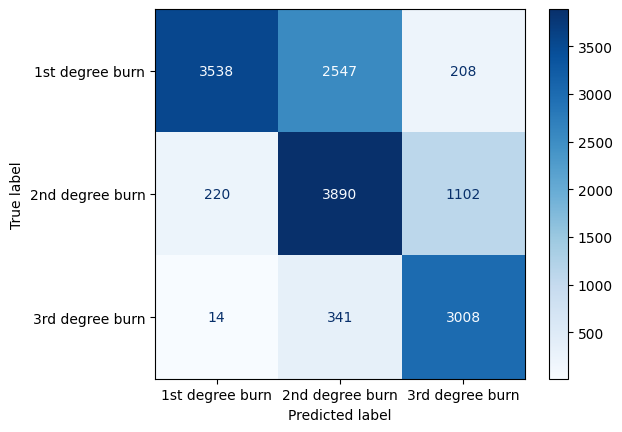

Epoch 1/10: Train Loss=0.7026, Train Accuracy=68.09%, Val Loss=0.9584, Val Accuracy=70.19%


100%|██████████| 1831/1831 [05:32<00:00,  5.51it/s]


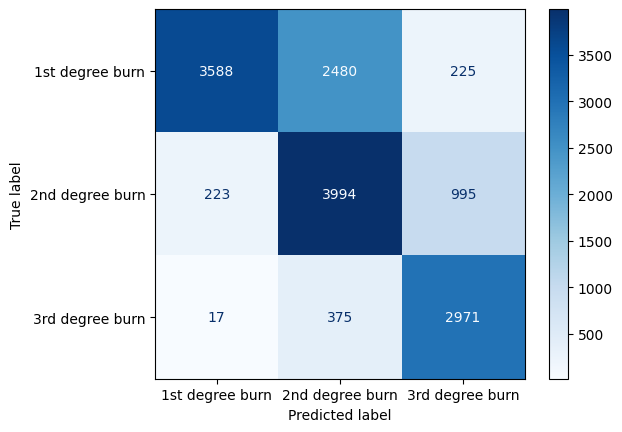

Epoch 2/10: Train Loss=0.5928, Train Accuracy=74.15%, Val Loss=1.2118, Val Accuracy=70.98%


100%|██████████| 1831/1831 [05:30<00:00,  5.54it/s]


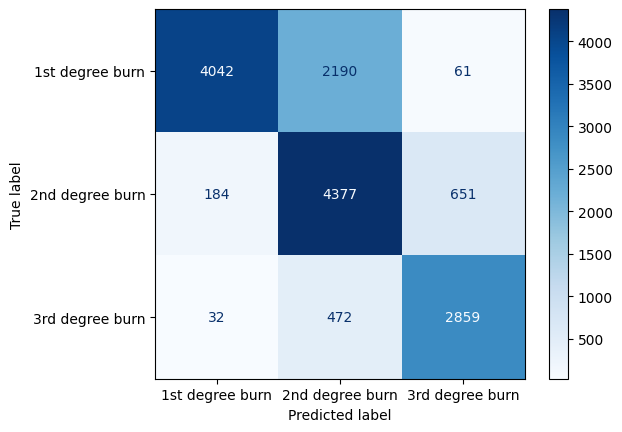

Epoch 3/10: Train Loss=0.5479, Train Accuracy=76.62%, Val Loss=0.6213, Val Accuracy=75.85%


100%|██████████| 1831/1831 [05:31<00:00,  5.53it/s]


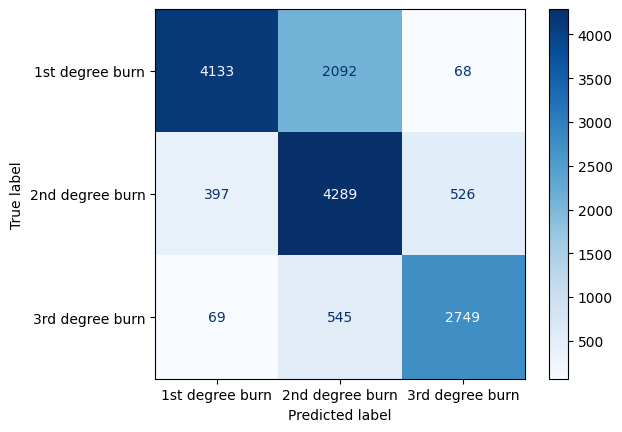

Epoch 4/10: Train Loss=0.5206, Train Accuracy=77.93%, Val Loss=0.8393, Val Accuracy=75.13%


100%|██████████| 1831/1831 [05:31<00:00,  5.52it/s]


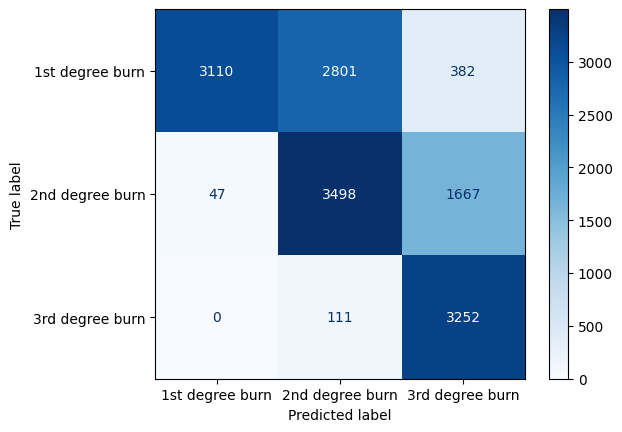

Epoch 5/10: Train Loss=0.4865, Train Accuracy=79.27%, Val Loss=1.0362, Val Accuracy=66.32%


100%|██████████| 1831/1831 [05:34<00:00,  5.47it/s]


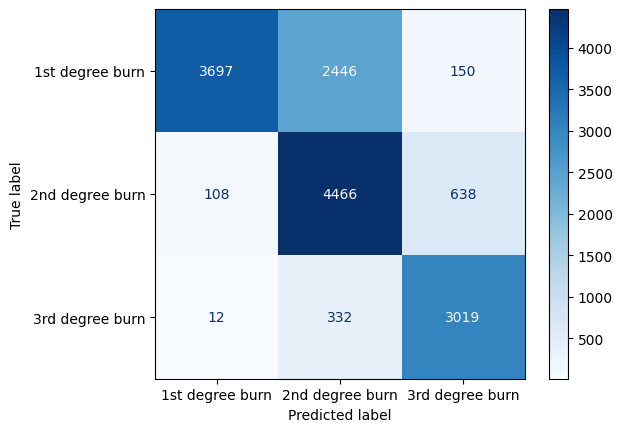

Epoch 6/10: Train Loss=0.3932, Train Accuracy=83.39%, Val Loss=0.9870, Val Accuracy=75.21%


100%|██████████| 1831/1831 [05:29<00:00,  5.56it/s]


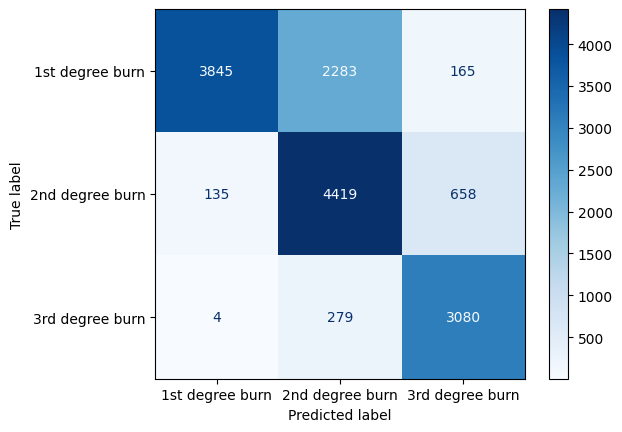

Epoch 7/10: Train Loss=0.3556, Train Accuracy=85.20%, Val Loss=1.0159, Val Accuracy=76.30%


100%|██████████| 1831/1831 [05:29<00:00,  5.56it/s]


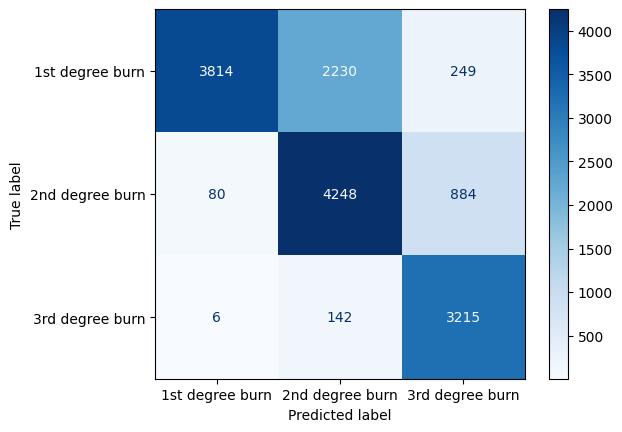

Epoch 8/10: Train Loss=0.3423, Train Accuracy=85.92%, Val Loss=0.9437, Val Accuracy=75.85%


100%|██████████| 1831/1831 [05:31<00:00,  5.52it/s]


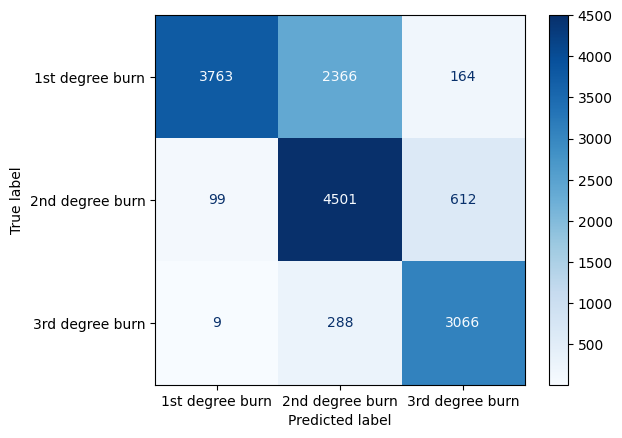

Epoch 9/10: Train Loss=0.3288, Train Accuracy=86.38%, Val Loss=1.1311, Val Accuracy=76.20%


100%|██████████| 1831/1831 [05:29<00:00,  5.56it/s]


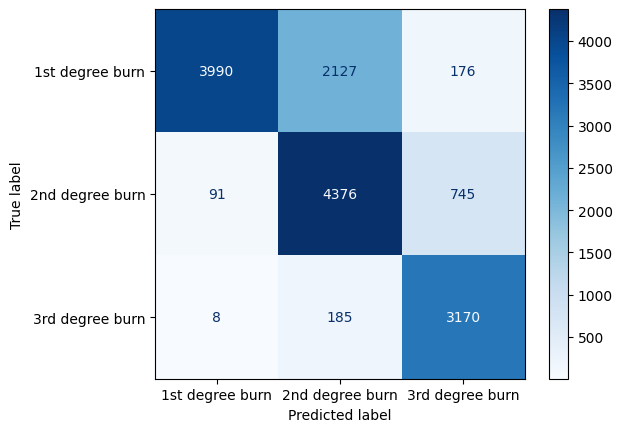

Epoch 10/10: Train Loss=0.3191, Train Accuracy=86.88%, Val Loss=0.8972, Val Accuracy=77.59%


In [8]:
num_epochs = 10
best_val_loss = float('inf')
patience = 3
counter = 0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy, true_labels, test_predictions = validate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Compute the confusion matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    class_names = ['1st degree burn', '2nd degree burn', '3rd degree burn']

    cm = confusion_matrix(true_labels, test_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.show()
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


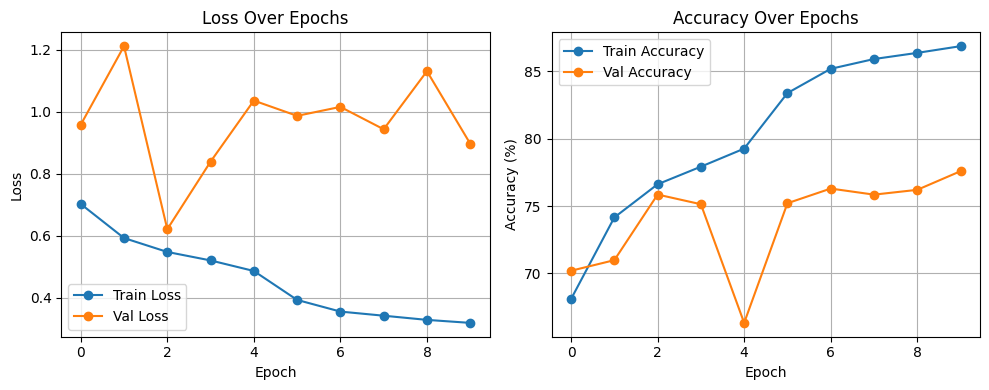

In [9]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='o')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


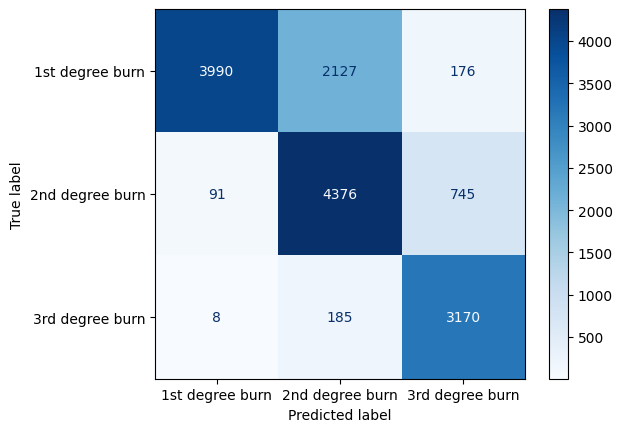

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(true_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.show()

In [ ]:
print(f"Testing samples: {len(test_dataset)}")

Testing samples: 200


In [ ]:
def predict_test(model, dataloader, device):
    predictions = []
    images_list = []  # To store the images for displaying

    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)  # Get the class with the highest score
            predictions.extend(preds.cpu().numpy())

            # Store the images for later visualization
            images_list.extend(images.cpu().numpy())

    return predictions, images_list

test_predictions, test_images = predict_test(model, test_loader, device)

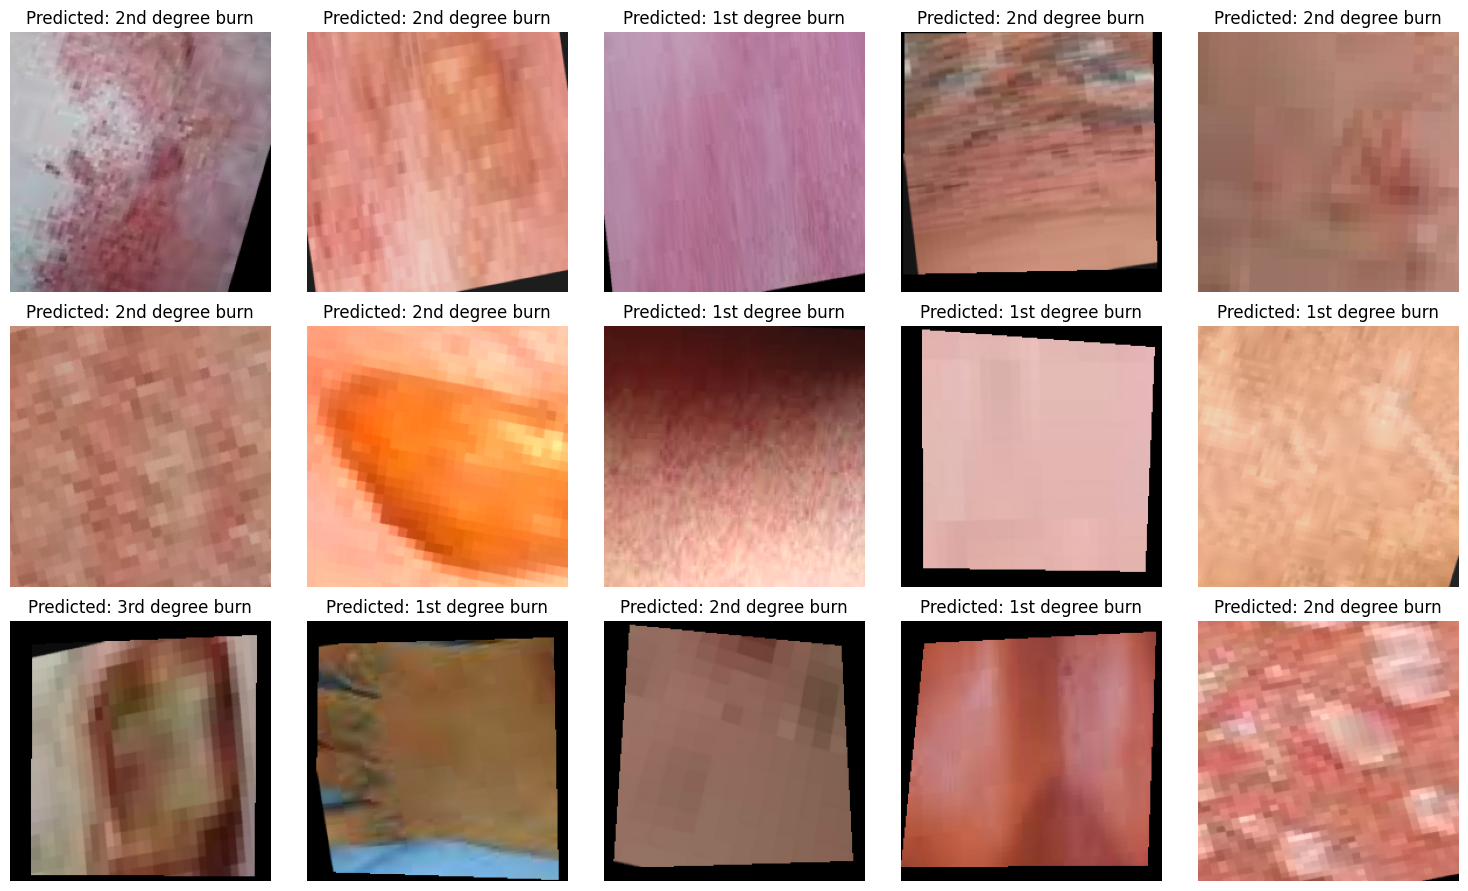

In [ ]:
import numpy as np

def denormalize_image(image, mean, std):
    for i in range(3):  # Assuming 3 channels (RGB)
        image[i] = image[i] * std[i] + mean[i]
    return image

def show_images_grid(images, predictions, class_names, mean, std, ncols=5):
    n_images = len(images)
    nrows = (n_images + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]

        # Denormalize and reshape the image
        img = denormalize_image(images[i], mean, std)
        img = np.transpose(img, (1, 2, 0))  # Change from (C, H, W) to (H, W, C)

        ax.imshow(img)
        ax.set_title(f"Predicted: {class_names[predictions[i]]}")
        ax.axis('off')

    for i in range(n_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

class_names = ['1st degree burn', '2nd degree burn', '3rd degree burn']
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

show_images_grid(test_images[:15], test_predictions[:15], class_names, mean, std, ncols=5)
